In [ ]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from gsw import rho
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import eigs
from scipy.integrate import cumtrapz
from matplotlib.pyplot import cm
import xrft

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## For CM2.6 data

In [ ]:
%cd /net2/smg/documents/OMDT/analysis_CM2p6/grids
os = xr.open_dataset('ocean.static.nc')
fs=xr.open_dataset('ocean_grid.nc')
depth=fs['ht'][:,:]

lon=fs['geolon_t']; lat=fs['geolat_t']
lat_u=fs['geolat_c']
# Coriolis is 2Omega sin(phi) where phi is the latitude of the B-grid velocity point, which should be available in hgrid
Coriolis = 2*7.29e-5*np.sin(fs['geolat_t']/360 *2*np.pi);
#dx = fs['dxt']; dy = fs['dyt']; dxy= (dx**2+dy**2)**0.5
#print(os,fs)

%cd /archive/Richard.Slater/CM2.6/CM2.6_A_Control-1860_V03/history

u = xr.open_dataset('02020101.ocean_minibling_field_u.nc')['u']
v = xr.open_dataset('02020101.ocean_minibling_field_v.nc')['v']
salt = xr.open_dataset('02020101.ocean_minibling_field_salt.nc')['salt']
temp = xr.open_dataset('02020101.ocean_minibling_field_temp.nc')['temp']

z = u.st_ocean
z_edges  = xr.open_dataset('02020101.ocean_minibling_field_u.nc')['st_edges_ocean']
thickness= z_edges.diff('st_edges_ocean').rename({'st_edges_ocean': 'st_ocean'}).assign_coords({"st_ocean":u.st_ocean})

#print(thickness)



## For CM2.5 data

In [199]:
%cd /work/eay/CM2.6/CM2.5_data
fs = xr.open_dataset('02020101.ocean_grid.nc')
depth=fs['ht'][:,:]

lon=fs['geolon_t']; lat=fs['geolat_t']
lat_u=fs['geolat_c']

u = xr.open_dataset('02020101.ocean_bgc_physics_field_u.nc')['u']
v = xr.open_dataset('02020101.ocean_bgc_physics_field_v.nc')['v']
temp = xr.open_dataset('02020101.ocean_bgc_physics_field_temp.nc')['temp']
salt = xr.open_dataset('02020101.ocean_bgc_physics_field_salt.nc')['salt']
z = u.st_ocean
z_edges  = xr.open_dataset('02020101.ocean_bgc_physics_field_u.nc')['st_edges_ocean']
thickness= z_edges.diff('st_edges_ocean').rename({'st_edges_ocean': 'st_ocean'}).assign_coords({"st_ocean":u.st_ocean})


# print(thickness)

/work2/eay/CM2.6/CM2.5_data


## For CM2-1deg data

In [232]:
%cd /work/eay/CM2.6/CM2_1deg_data
fs = xr.open_dataset('02000101.ocean_grid.nc')
depth=fs['ht'][:,:]

lon=fs['geolon_t']; lat=fs['geolat_t']
lat_u=fs['geolat_c']

u = xr.open_dataset('02000101.ocean_bgc_physics_field_u.nc')['u']
v = xr.open_dataset('02000101.ocean_bgc_physics_field_v.nc')['v']
temp = xr.open_dataset('02000101.ocean_bgc_physics_field_temp.nc')['temp']
salt = xr.open_dataset('02000101.ocean_bgc_physics_field_salt.nc')['salt']
z = u.st_ocean
z_edges  = xr.open_dataset('02000101.ocean_bgc_physics_field_u.nc')['st_edges_ocean']
thickness= z_edges.diff('st_edges_ocean').rename({'st_edges_ocean': 'st_ocean'}).assign_coords({"st_ocean":u.st_ocean})

# print(thickness)

/work2/eay/CM2.6/CM2_1deg_data


In [5]:
density_np = rho(salt[-1,:,:,:],temp[-1,:,:,:],0)
density = xr.DataArray(density_np,dims   = ['st_ocean','yt_ocean','xt_ocean'],coords={'xt_ocean':temp.xt_ocean,'yt_ocean':temp.yt_ocean,'st_ocean':temp.st_ocean})
drhodz = density.differentiate('st_ocean')

N2 = (9.8*drhodz/1025)
mask = temp[0,:]*0.+1.
thickness_full = mask*thickness
positions = thickness_full.cumsum('st_ocean')*mask


In [6]:

# solves G''(z) + (N^2(z) - omega^2)G(z)/c^2 = 0 G is vertical structure of isopycnal displacement, units m.
#dG/dz = F(z) (here called Gz), vertical structure of horizontal velocity and is unitless

#   subject to G'(0) = gG(0)/c^2 (free surface) & G(-D) = 0 (flat bottom)
# G(z) is normalized so that the vertical integral of (G'(z))^2 is D
# G' is dimensionless, G has dimensions of length

# - N is buoyancy frequency [s^-1] (nX1 vector)
# - depth [m] (maximum depth is considered the sea floor) (nX1 vector)
# - omega is frequency [s^-1] (scalar)
# - mmax is the highest baroclinic mode calculated
# - m=0 is the barotropic mode
# - 0 < m <= mmax are the baroclinic modes
# - Modes are calculated by expressing in finite difference form 1) the
#  governing equation for interior depths (rows 2 through n-1) and 2) the
#  boundary conditions at the surface (1st row) and the bottome (last row).
# - Solution is found by solving the eigenvalue system A*x = lambda*B*x
def vertical_modes(N2_0, Depth, omega, mmax):
    z = -1 * Depth

    if np.size(np.shape(N2_0)) > 1:
        N2 = np.nanmean(N2_0, axis=1)
    else:
        N2 = N2_0

    n = np.size(z)
    nm1 = n - 1
    nm2 = n - 2
    gravity = 9.82
    # ----- vertical increments
    dz = np.concatenate([[0], z[1:] - z[0:nm1]])  # depth increment [m]
    dzm = np.concatenate([[0], 0.5 * (z[2:] - z[0:nm2]), [0]])  # depth increment between midpoints [m]
    # ----- sparse matrices
    # A = row pos, B = col pos, C = val  
    A = np.concatenate([[0], [0], np.arange(1, nm1), np.arange(1, nm1), np.arange(1, nm1), [n - 1]])
    B = np.concatenate([[0], [1], np.arange(1, nm1), np.arange(0, nm2), np.arange(2, n), [n - 1]])
    C = np.concatenate(
        [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
         -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
        # [[-1 / dz[1]], [1 / dz[1]], (1 / dz[2:] + 1 / dz[1:nm1]) / dzm[1:nm1], -1 / (dz[1:nm1] * dzm[1:nm1]),
        #  -1 / (dz[2:n] * dzm[1:nm1]), [-1]])
    mat1 = coo_matrix((C, (A, B)), shape=(n, n))

    D = np.concatenate([[0], np.arange(1, n)])
    E = np.concatenate([[0], np.arange(1, n)])
    F = np.concatenate([[gravity], N2[1:] - omega * omega])  # originially says N2[1:,10]
    mat2 = coo_matrix((F, (D, E)), shape=(n, n))

    # compute eigenvalues and vectors 
    vals, vecs = eigs(mat1, k=mmax + 1, M=mat2, sigma=0)
    eigenvalue = np.real(vals)
    wmodes = np.real(vecs)
    s_ind = np.argsort(eigenvalue)
    eigenvalue = eigenvalue[s_ind]
    wmodes = wmodes[:, s_ind]
    m = np.size(eigenvalue)
    c = 1 / np.sqrt(eigenvalue)  # kelvin wave speed
    # normalize mode (shapes)
    Gz = np.zeros(np.shape(wmodes))
    G = np.zeros(np.shape(wmodes))
    for i in range(m):
        dw_dz = np.nan * np.ones(np.shape(z))
        dw_dz[0] = (wmodes[1, i] - wmodes[0, i]) / (z[1] - z[0])
        dw_dz[-1] = (wmodes[-1, i] - wmodes[-2, i]) / (z[-1] - z[-2])
        for j in range(1, len(z) - 1):
            dw_dz[j] = (wmodes[j + 1, i] - wmodes[j - 1, i]) / (z[j + 1] - z[j - 1])
        # dw_dz = np.gradient(wmodes[:, i], z)
        norm_constant = np.sqrt(np.trapz((dw_dz * dw_dz), (-1 * z)) / (-1 * z[-1]))
        # norm_constant = np.abs(np.trapz(dw_dz * dw_dz, z) / Depth.max())

        if dw_dz[0] < 0:
            norm_constant = -1 * norm_constant
        Gz[:, i] = dw_dz / norm_constant

        norm_constant_G = np.sqrt(np.trapz((wmodes[:, i] * wmodes[:, i]), (-1 * z)) / (-1 * z[-1]))
        G[:, i] = wmodes[:, i] / norm_constant

    #epsilon = np.nan * np.zeros((5, 5, 5))  # barotropic and first 5 baroclinic
    #for i in range(0, 5):  # i modes
    #    for j in range(0, 5):  # j modes
    #        for m in range(0, 5):  # k modes
    #            epsilon[i, j, m] = np.trapz((Gz[:, i] * Gz[:, j] * Gz[:, m]), -1.0*z) / (-1.0*z[-1])

    return G, Gz, c#, epsilon
#G is the displacement modes and Gz is velocity modes (Gz = dG/dz = F)



In [7]:
N2.shape

(50, 2700, 3600)

In [8]:
positions

<xarray.DataArray (st_ocean: 50, yt_ocean: 2700, xt_ocean: 3600)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03
    time      object 0202-01-03 12:00:00

In [12]:
#AT ONE POINT in Argentine Basin:
lati=767; loni=2374; #CM2.6
#lati=297; loni=949;  #CM2.5
#lati= 38; loni= 238; #CM2-1deg

N2_ij = np.array(N2[:,lati,loni])
N2_filtered= np.abs(N2_ij[~np.isnan(N2_ij)])

        
positions_ij = np.array(positions[:,lati,loni])
positions_filtered= positions_ij[~np.isnan(N2_ij)]

if N2_filtered.size>=7:
    if np.nanmin(N2_filtered>0):
        nmodes= 4
        [G, Gz, c]=vertical_modes(N2_filtered, positions_filtered, 0, nmodes) #nmodes is number of BC modes, doens't include BT mode


In [13]:
N2

<xarray.DataArray (st_ocean: 50, yt_ocean: 2700, xt_ocean: 3600)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 5.034 15.1 25.22 ... 5.185e+03 5.395e+03

In [14]:
#nmodes=len(N2_filtered)-3
BT_KE=np.zeros(10)
BC_KE=np.zeros(10)
KE_u_t=np.zeros([10,5])
KE_v_t=np.zeros([10,5])

for i in range(0,10):
    ui=u[i,~np.isnan(N2_ij),lati,loni]; vi=v[i,~np.isnan(N2_ij),lati,loni];
        
    amp_u=np.linalg.lstsq(Gz,ui)[0]
    amp_v=np.linalg.lstsq(Gz,vi)[0]  #solving for alpha, units of m/s
    print(i)
    BT_KE[i]=0.5*amp_u[0]**2+0.5*amp_v[0]**2
    BC_KE[i]=np.nansum(0.5*amp_u[1:]**2)+np.nansum(0.5*amp_v[1:]**2)
    
    KE_u_t[i,0:nmodes+1]=0.5*amp_u[:]**2 #has modes 
    KE_v_t[i,0:nmodes+1]=0.5*amp_v[:]**2
print('done')

0
1
2
3
4
5
6
7
8
9
done


In [15]:
mask_2D = depth*0+1.

In [16]:
vorticity1=u[0,0,:,:].differentiate('yu_ocean')*360/(2*np.pi*6378000)
vorticity2=v[0,0,:,:].differentiate('xu_ocean')*360/(2*np.pi*6378000*np.cos(u.yu_ocean*np.pi/180))
vorticity=vorticity2-vorticity1

In [17]:
vorticity1.shape

(2700, 3600)

In [18]:
print(vorticity)
vorticity=np.array(vorticity)*mask_2D
print(vorticity)

<xarray.DataArray (yu_ocean: 2700, xu_ocean: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * xu_ocean  (xu_ocean) float64 -279.9 -279.8 -279.7 -279.6 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 -81.09 -81.05 -81.0 -80.96 ... 89.92 89.96 90.0
    st_ocean  float64 5.034
    time      object 0202-01-03 12:00:00
<xarray.DataArray 'ht' (yt_ocean: 2700, xt_ocean: 3600)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * y

In [19]:
vorticity.shape

(2700, 3600)

Text(0.5, 1.0, 'Depth [m]')

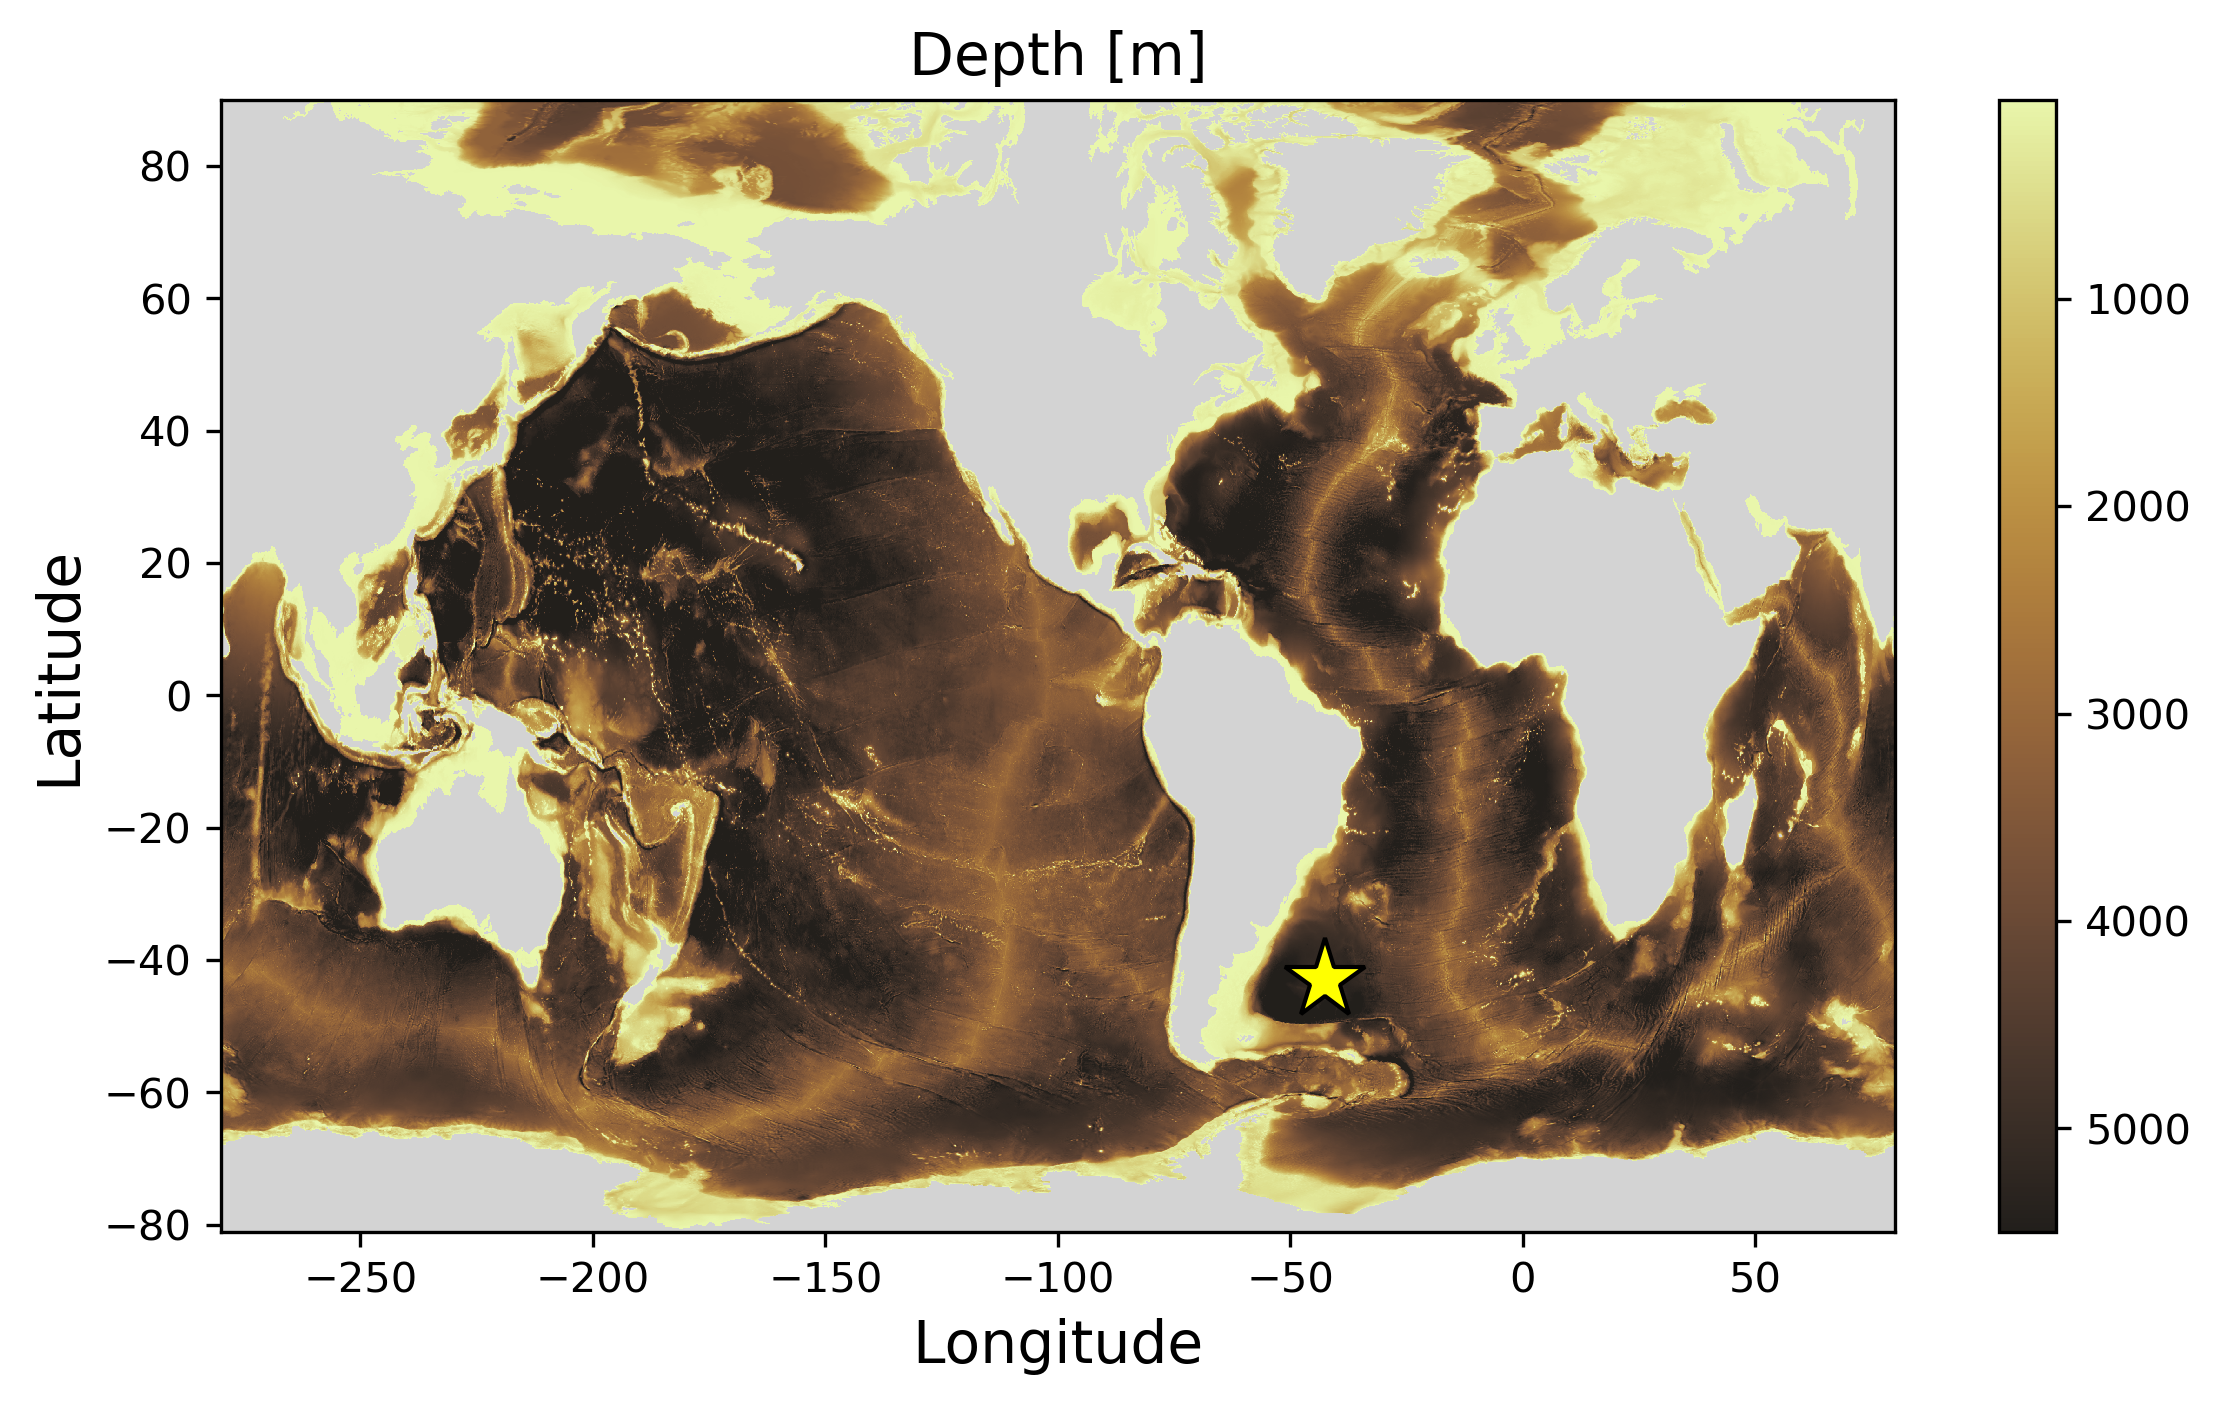

In [22]:
fig = plt.figure(figsize=(9, 5), dpi= 300, facecolor='w', edgecolor='k')

plot1=depth.plot(cmap=cmocean.cm.turbid,add_colorbar=False)
cb=plt.colorbar(plot1)
cb.ax.invert_yaxis()
plt.plot(lon[lati,loni],lat[lati,loni],'*',markerfacecolor=[1,1,0],markeredgecolor='k',Markersize=20)

current_cmap = plot1.get_cmap()
current_cmap.set_bad(color='#D3D3D3')

plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.title('Depth [m]',fontsize=14)

In [ ]:
fig = plt.figure(figsize=(9, 5), dpi= 300, facecolor='w', edgecolor='k')

plot1=vorticity.plot(vmin=-1.5e-5,vmax=1.5e-5,cmap=cmocean.cm.curl,add_colorbar=False,xlim=[-100,-20],ylim=[-70,-30])
plt.colorbar(plot1, format='%.2e')
plt.plot(lon[lati,loni],lat[lati,loni],'*',markerfacecolor=[1,1,0],markeredgecolor='k',Markersize=20)

current_cmap = plot1.get_cmap()
current_cmap.set_bad(color='#D3D3D3')

plt.xlabel('Longitude',fontsize=14)
plt.ylabel('Latitude',fontsize=14)
plt.title('Surface vorticity [$1/s$], CM2.6deg',fontsize=14)
#
# plot1.set_xlim([-100,0])
# plot1.set_ylim([-80,-20])

In [18]:
vorticity.shape

(2700, 3600)

Text(0.5, 1.0, '5 total modes')

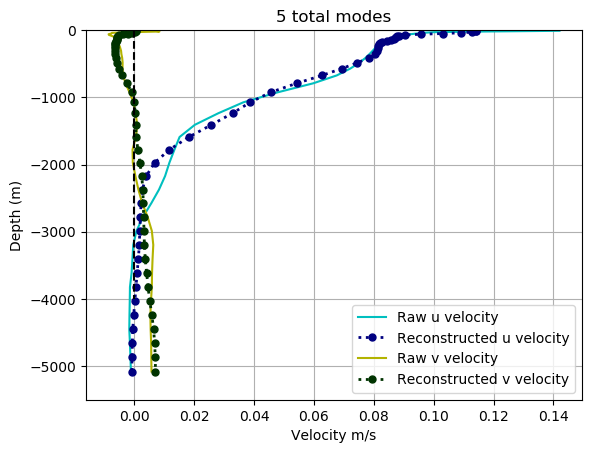

In [248]:
plt.style.use('default')


plt.plot(ui,-positions_filtered,c='c')
plt.plot(np.nansum(Gz*amp_u,axis=1),-positions_filtered,'.:',c=[0., 0., 0.5],linewidth=2,markersize=10)

plt.plot(vi,-positions_filtered,c=[0.7, 0.7, 0])
plt.plot(np.nansum(Gz*amp_v,axis=1),-positions_filtered,'.:',c=[0., 0.2, 0.],linewidth=2,markersize=10)

plt.grid()
plt.plot([0, 0],[0, -4000],'--',color=[0,0,0])

#plt.xlim(-.3, .3)
plt.ylim(-5500, 0);
plt.xlabel('Velocity m/s')
plt.legend(['Raw u velocity','Reconstructed u velocity','Raw v velocity','Reconstructed v velocity'])
plt.ylabel('Depth (m)')
plt.title('%i total modes' % (nmodes+1))


0
1
2
3
4


Text(0.5, 1.0, 'Horizontal velocity modes')

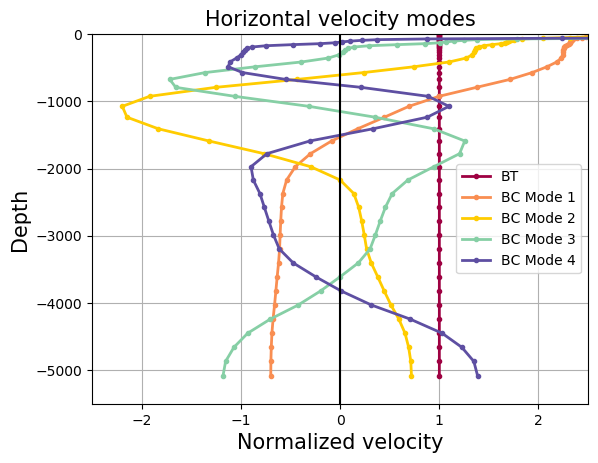

In [249]:
color=iter(cm.Spectral(np.linspace(0,1,nmodes+1))) #rainbow
plt.style.use('default')
for i in range(nmodes+1):
    print(i)
    c=next(color)
    if i == 2:
        c = '#FFCC00'
    plt.plot(Gz[:,i],-positions_filtered,'.-',c=c,Linewidth=2)
plt.grid()
plt.legend(['BT','BC Mode 1','BC Mode 2','BC Mode 3','BC Mode 4','BC Mode 5','BC Mode 6','BC Mode 7','BC Mode 8','BC Mode 9','BC Mode 10','BC Mode 11'])
plt.plot([0, 0],[0, -5500],color=[0,0,0])
plt.xlim(-2.5, 2.5)
plt.ylim(-5500, 0);
plt.xlabel('Normalized velocity',fontsize=15)
plt.ylabel('Depth',fontsize=15)
plt.title('Horizontal velocity modes',fontsize=15)

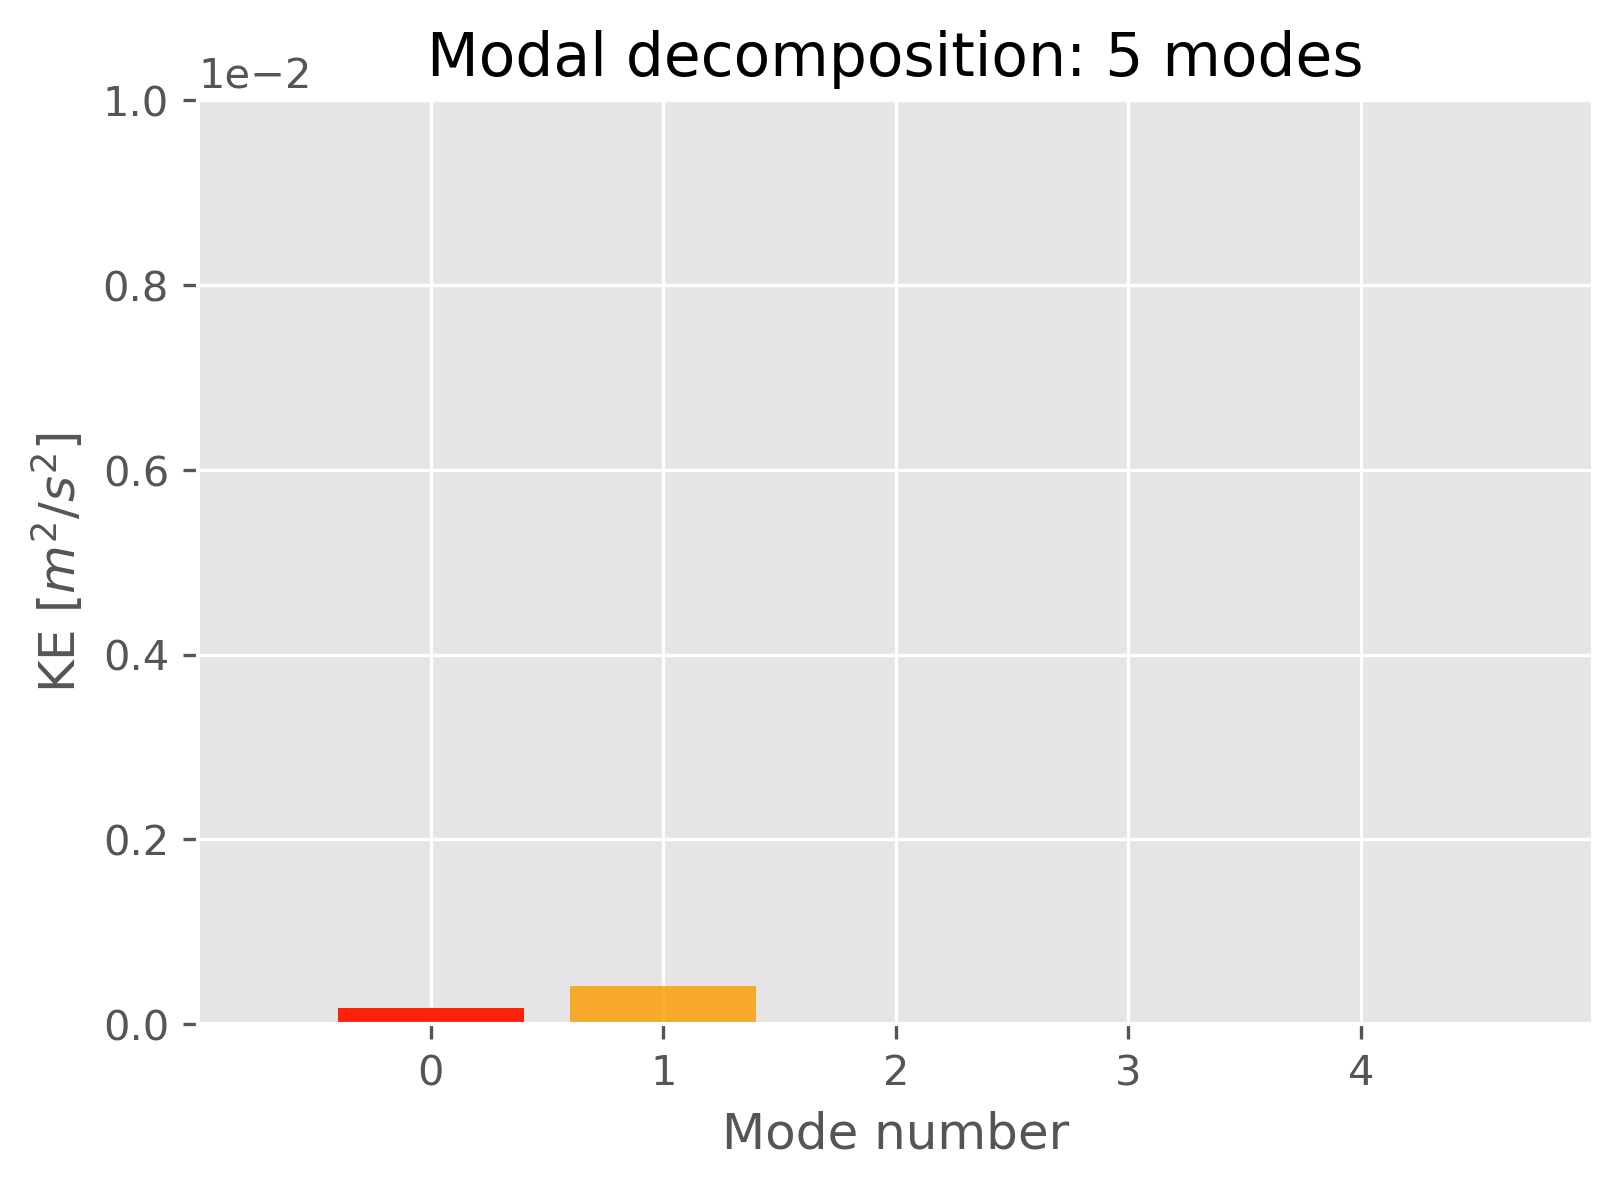

In [250]:

fig = plt.figure(figsize=(6, 4), dpi= 300, facecolor='w', edgecolor='k')
plt.style.use('ggplot')
x = np.linspace(0,4,5)
amp1 = np.nanmean(KE_u_t+KE_v_t,axis=0)

plt.bar(x, amp1, color=[1., .6, 0.],alpha=0.8)
plt.bar(x[0], amp1[0], color=[1., .0, 0.],alpha=0.8)

plt.xlabel("Mode number")
plt.ylabel("KE [$m^2/s^2$]")
plt.title("Modal decomposition: %i modes" % (nmodes+1))
#plt.ylim(0,3e-2)
plt.ylim(0,1e-2)
plt.xlim(-1,5)
plt.xticks((0,1,2,3,4))
plt.ticklabel_format(axis="y", style="sci",scilimits=(0,0))

In [251]:
#FOR A 2D REGION:
region = 20 #200
u_s = u[:,0,lati,loni-region:loni+region]
v_s = v[:,0,lati,loni-region:loni+region]



In [252]:

print(u_s.yu_ocean)

<xarray.DataArray 'yu_ocean' ()>
array(-43.)
Coordinates:
    yu_ocean  float64 -43.0
    st_ocean  float64 5.034
Attributes:
    long_name:       ucell latitude
    units:           degrees_N
    cartesian_axis:  Y


In [253]:

xnew= ((u_s.xu_ocean)*(2*np.pi*6378000*np.cos(u_s.yu_ocean*np.pi/180))/360).values #*np.cos(u_s.yu_ocean[region]*np.pi/180)

#xnew = xr.DataArray(xnew,coords=[xnew],dims='xnew')

# ynew= (u_s.yu_ocean)*(2*np.pi*6378000)/360
# ynew= (np.linspace(np.min(ynew),np.max(ynew),40))


unew = xr.DataArray(u_s.values, coords=[u_s.time,xnew],dims=["time","xnew"])
vnew = xr.DataArray(v_s.values, coords=[u_s.time,xnew],dims=["time","xnew"])
print(unew)

<xarray.DataArray (time: 73, xnew: 40)>
array([[0.03137179, 0.04218728, 0.05962789, ..., 0.15463465, 0.14178891,
        0.12841636],
       [0.02422489, 0.03168781, 0.04587261, ..., 0.084915  , 0.07540188,
        0.06753889],
       [0.06807736, 0.08077382, 0.10283832, ..., 0.13910078, 0.13088802,
        0.120592  ],
       ...,
       [0.03883288, 0.04479662, 0.05737869, ..., 0.12357356, 0.13260138,
        0.13354753],
       [0.05671539, 0.06608223, 0.07580041, ..., 0.14395219, 0.1325989 ,
        0.11654692],
       [0.03039348, 0.04132871, 0.05585699, ..., 0.15289672, 0.14334913,
        0.12789749]], dtype=float32)
Coordinates:
  * time     (time) object 0200-01-03 12:00:00 ... 0200-12-28 12:00:00
  * xnew     (xnew) float64 -4.966e+06 -4.885e+06 ... -1.872e+06 -1.791e+06


In [254]:
unew

<xarray.DataArray (time: 73, xnew: 40)>
array([[0.03137179, 0.04218728, 0.05962789, ..., 0.15463465, 0.14178891,
        0.12841636],
       [0.02422489, 0.03168781, 0.04587261, ..., 0.084915  , 0.07540188,
        0.06753889],
       [0.06807736, 0.08077382, 0.10283832, ..., 0.13910078, 0.13088802,
        0.120592  ],
       ...,
       [0.03883288, 0.04479662, 0.05737869, ..., 0.12357356, 0.13260138,
        0.13354753],
       [0.05671539, 0.06608223, 0.07580041, ..., 0.14395219, 0.1325989 ,
        0.11654692],
       [0.03039348, 0.04132871, 0.05585699, ..., 0.15289672, 0.14334913,
        0.12789749]], dtype=float32)
Coordinates:
  * time     (time) object 0200-01-03 12:00:00 ... 0200-12-28 12:00:00
  * xnew     (xnew) float64 -4.966e+06 -4.885e+06 ... -1.872e+06 -1.791e+06

In [257]:
#uiso2 = xrft.isotropic_power_spectrum(unew[0:40,0:40],dim=['ynew','xnew'],detrend='linear').compute()

uiso2 = xrft.power_spectrum(unew,dim=['xnew'], scaling="density",window='hann', detrend='linear').compute() #,
viso2 = xrft.power_spectrum(vnew,dim=['xnew'], scaling="density",window='hann', detrend='linear').compute() #,

ekeiso = .5*(uiso2 + viso2)#.mean('time')

nk = int(len(ekeiso[0,:])/2.)

ekeiso=ekeiso[:,nk+1:]    # half of the latitude array size
wavenumber= (ekeiso.freq_xnew*1e3*2*np.pi)
#uiso2 = xrft.isotropic_power_spectrum(u_small,dim=['x5km','y5km'], detrend='linear').compute()



In [258]:
wavenumber21=wavenumber
ekeiso21=ekeiso

Text(0, 0.5, '[m$^3$ s$^{-2}$]')

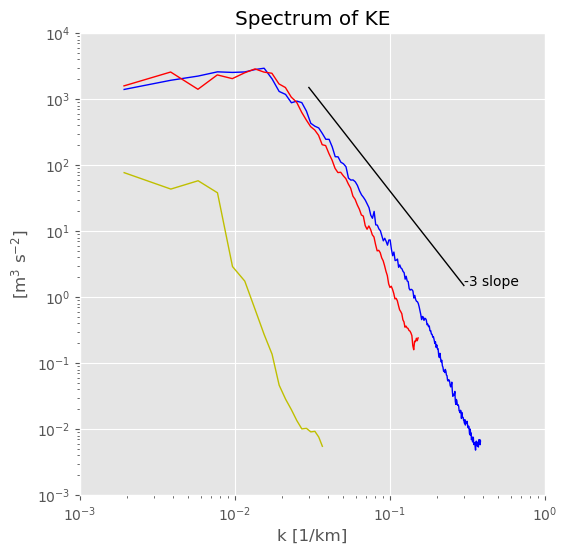

In [259]:
fig, ax = plt.subplots(figsize=(6,6))


#plt.plot(alt_freq[1:],alt_PS[0,1:],'-*r',linewidth=4)  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber
plt.plot(wavenumber26,ekeiso26.mean('time'),'-b',linewidth=1)  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber
plt.plot(wavenumber25,ekeiso25.mean('time'),'-r',linewidth=1)  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber
plt.plot(wavenumber21,ekeiso21.mean('time'),'-y',linewidth=1)  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber


plt.plot([3e-2, 3e-1],[1.5e3, 1.5e0],'-k',linewidth=1)  ### multiply 1e3 just because we want to transfer unit from cycles/m to cycles/km and 2pi to get wavenumber

plt.text(3e-1,1.5e0,'-3 slope')


plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of KE')#, Y=%.0f degrees'%)
plt.ylim([1e-3, 1e4])
plt.xlim([1e-3, 1e0])
plt.grid('on')
plt.xlabel('$\kappa_r (1/km)$')
#plt.legend(fontsize=14)

ax.set_xlabel(r'k [1/km]')
ax.set_ylabel(r'[m$^3$ s$^{-2}$]')



In [182]:
ekeiso

<xarray.DataArray (time: 36, freq_xnew: 400)>
array([[0.0023762 , 0.00724017, 0.00976789, ..., 0.01116823, 0.00976789,
        0.00724017],
       [0.00637386, 0.00789396, 0.002218  , ..., 0.00454929, 0.002218  ,
        0.00789396],
       [0.00396405, 0.00510352, 0.00449616, ..., 0.00459571, 0.00449616,
        0.00510352],
       ...,
       [0.00177484, 0.0013027 , 0.00105293, ..., 0.00182538, 0.00105293,
        0.0013027 ],
       [0.00022445, 0.0005781 , 0.0005203 , ..., 0.00456897, 0.0005203 ,
        0.0005781 ],
       [0.00480777, 0.00267233, 0.00063814, ..., 0.00051671, 0.00063814,
        0.00267233]])
Coordinates:
  * time       (time) object 0202-07-07 12:00:00 ... 0202-12-29 12:00:00
  * freq_xnew  (freq_xnew) float64 -6.14e-05 -6.11e-05 ... 6.079e-05 6.11e-05

In [91]:
help(xrft.isotropic_power_spectrum)

Help on function isotropic_power_spectrum in module xrft.xrft:

isotropic_power_spectrum(da, spacing_tol=0.001, dim=None, shift=True, detrend=None, scaling='density', window=None, window_correction=False, nfactor=4, truncate=False, **kwargs)
    Calculates the isotropic spectrum from the
    two-dimensional power spectrum by taking the
    azimuthal average.
    
    .. math::
                ext{iso}_{ps} = k_r N^{-1} \sum_{N} |\mathbb{F}(da')|^2
    
    where :math:`N` is the number of azimuthal bins.
    
    Note: the method is not lazy does trigger computations.
    
    Parameters
    ----------
    da : `xarray.DataArray`
        The data to be transformed
    spacing_tol: float, optional
        Spacing tolerance. Fourier transform should not be applied to uneven grid but
        this restriction can be relaxed with this setting. Use caution.
    dim : list, optional
        The dimensions along which to take the transformation. If `None`, all
        dimensions will be transf

In [83]:
uiso2 = xrft.power_spectrum(uline,dim=['xh'], scaling="density",window='hann', detrend='linear').compute() #, window='hann/hamming', detrend='linear'
viso2 = xrft.power_spectrum(vline,dim=['xh'], scaling="density",window='hann', detrend='linear').compute()

NameError: name 'uline' is not defined